In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import seaborn as sns

In [2]:
data = np.load("../data/train/2013-11-01.npy")
train_raw = np.load("../data/train_raw.npy")
val_raw = np.load("../data/val_raw.npy")
test_raw = np.load("../data/test_raw.npy")
full_raw = np.concatenate((train_raw, val_raw, test_raw))
train = np.load("../data/train.npy")
val = np.load("../data/val.npy")

#### We have 1 datapoint per 10 minutes, resulting in 144 data points per day

In [3]:
data.shape

(144, 100, 100)

In [19]:
def draw_grid(strip_labels=False):
    plt.rcParams.update({'font.size': 15})  
    plt.figure(figsize=(5.5, 4))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    dots1 = data[96]  # 15:00 UTC,  16:00 local Milan time
    img = ax.imshow(dots1, origin='lower')
    # cb = plt.colorbar(img, cax = cbaxes, cmap='terrain')

    # plt.style.use('default')

    ax.pcolormesh(dots1, cmap='terrain', vmin=dots1.min(), vmax=1000)

    if strip_labels:
        plt.xticks([])
        plt.yticks([])
        
        plt.savefig("grid_nolabels.pdf", bbox_inches='tight')
        return
    
    ax.set_ylabel("y coordinate")
    ax.set_xlabel("x coordinate")

    # Adding the colorbar
    cbaxes = fig.add_axes([0.02, 0.1, 0.03, 0.8])  # This is the position for the colorbar
    cb = plt.colorbar(img, cax = cbaxes, label="Traffic volume (CDRs)")


    cbaxes.yaxis.set_ticks_position('left')

    # plt.tight_layout()

    plt.savefig("grid.pdf", bbox_inches='tight')



<Figure size 396x288 with 0 Axes>

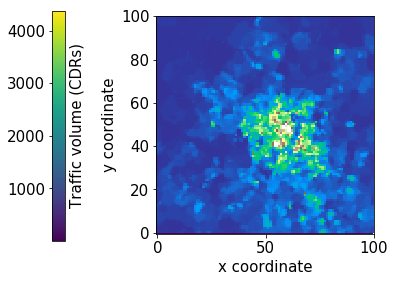

In [22]:
draw_grid(strip_labels=False)

In [25]:
from matplotlib.font_manager import findfont, FontProperties
findfont(FontProperties(family=['sans-serif']))


'/Users/dziugas/anaconda3/envs/msc/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [20]:
def plot_cell(cell_data, ax=None):
                        #  24 hours,  10 minute steps 
    x_grid = np.arange(0, cell_data.shape[0] / 6, 1 / 6)
    
    plt.style.use('seaborn-whitegrid')
    
    if ax is None:
        ax = plt.axes()
    ax.plot(x_grid, cell_data, linewidth=0.85)


In [177]:
def plot_various_cells(data):
    cell_coords = [
        [(45, 58), (47, 55), (50, 60)],
        [(45, 65), (55, 65), (55, 55)]
    ]
    fig, axis_grid = plt.subplots(2, 3, sharey=True, figsize=(18, 8))

    for line_coords, axis in zip(cell_coords, axis_grid):
        for coords, ax in zip(line_coords, axis):
            cell_data = data[:, coords[0], coords[1]]

            plot_cell(cell_data, ax)

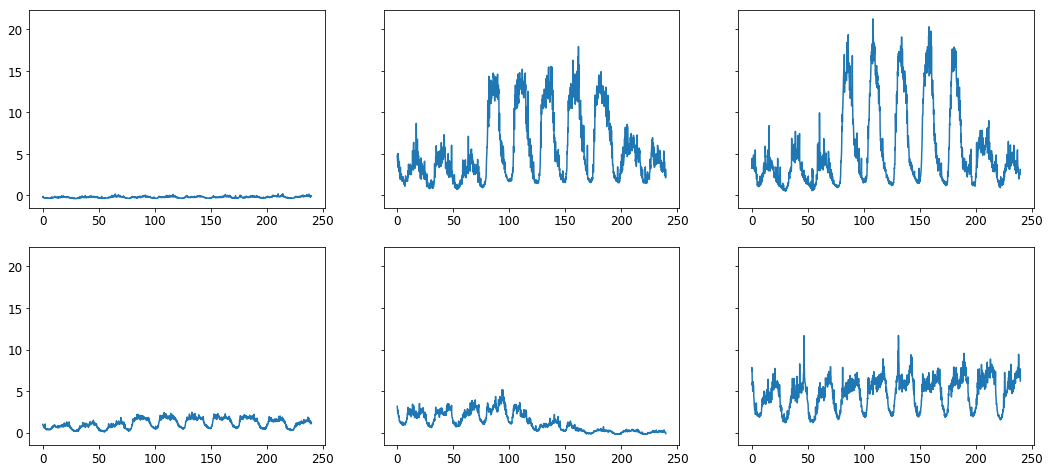

In [178]:
plot_various_cells(train[:1440])

In [8]:
data_1 = train_raw[144*3:1008 + 144*3, 70, 25] # 7 days from Monday
data_2 = train_raw[144*3:1008 + 144*3, 45, 45]

min_y = min(data_1.min(), data_2.min()) - 25
max_y = max(data_1.max(), data_2.max()) - 12

In [11]:
def plot_week(data, min_y, max_y, file=None):
    plt.rcParams.update({'font.size': 15}) 
    fig, axis = plt.subplots(1, 1, sharey=True, figsize=(6, 3))
    axis.set_ylim([min_y, max_y])
    axis.set_xlim(0, 168)
    plot_cell(data, axis)
    plt.xlabel("Day of the week")
    plt.ylabel("Traffic volume (CDRs)")
    axis.yaxis.set_label_position("right")
    axis.yaxis.tick_right()
    plt.xticks(range(12,157,24), ["Mon", "Tue", "Wed", "Th", "Fr", "Sat", "Sun"])
    
    if file:
        plt.savefig(file)

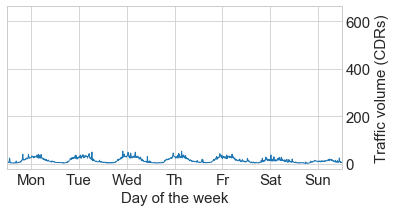

In [18]:
plot_week(data_1, min_y, max_y, file="week_low.svg")

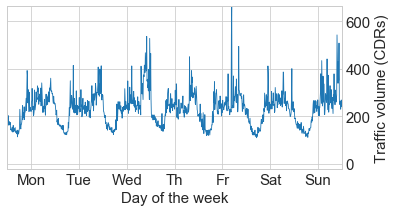

In [21]:
plot_week(data_2, min_y, max_y, file="week_high.svg")

## Data Range and Outlier analysis

In [9]:
import scipy.stats as sts

def stats(data):
    print(f"mean: {data.mean()}")
    print(f"std: {data.std()}")
    print(f"min: {data.min()}")
    print(f"max: {data.max()}")
    

In [10]:
stats(data)

mean: 57.27725457618373
std: 94.69406484079856
min: 0.0
max: 5063.972006037141


In [11]:
print("TRAIN:")
stats(train_raw)
print("\nVAL:")
stats(val_raw)

TRAIN:
mean: 67.61768898039853
std: 132.47248595705986
min: 0.0
max: 8044.070569441475

VAL:
mean: 58.91781573321698
std: 112.66105591336199
min: 0.0
max: 5752.094179354247


In [12]:
from scipy.stats import iqr

# Lets investigate outliers using Tukey's fences
def analize_iqr_outliers(volumes):
    iqrange = iqr(volumes)
    first_quartile = np.quantile(volumes, 0.25)
    third_quartile = np.quantile(volumes, 0.75)

    print("Interquartile range: {0}".format(iqrange))
    print("First quartile: {0}".format(first_quartile))
    print(f"third_quartile: {third_quartile}")

    k = 1.5
    outlier_threshold = third_quartile + k * iqrange

    outliers = volumes[volumes > outlier_threshold]

    print("There are: {0} points considered as outliers".format(len(outliers)))
    print("Which makes: {0}% of the data".format(len(outliers) / np.size(volumes) * 100))

In [13]:
analize_iqr_outliers(data)

Interquartile range: 51.93908519555043
First quartile: 10.70288904168552
third_quartile: 62.64197423723596
There are: 141291 points considered as outliers
Which makes: 9.811875% of the data


**Amplitude distributions in the central area**

In [12]:
# central_range_x = np.arange(45, 55)
# central_range_y = np.arange(55, 65)
# for x, y in zip(central_range_x, central_range_y):
#     plot_cell(data[:, x, y])

# GRAPH WITH BUNCH OF LINES

In [15]:
central_region = data[:, central_range_x[0]:central_range_x[-1], central_range_y[0]:central_range_y[-1]]
analize_iqr_outliers(central_region)

Interquartile range: 274.3909521627498
First quartile: 188.87529075057336
third_quartile: 463.26624291332314
There are: 662 points considered as outliers
Which makes: 5.675582990397805% of the data


**Seems tempting to remove outliers:**

In [36]:
def plot_single_histogram(data):
    plt.figure(figsize=(7, 3.5))
    plt.rcParams.update({'font.size': 14})
    plt.xlabel("Traffic volume (CDRs)")
    plt.ylabel("Fraction of data")
    plt.style.use('seaborn-whitegrid')
    
    outliers_removed = data[data < 1200]
    sns.distplot(outliers_removed, kde_kws={"linewidth": 2})
    
    plt.savefig("hist.pdf")

def plot_histograms(data):
    plt.figure(figsize=(15, 4))
    
    
    plt.subplot(1, 2, 1)
    sns.distplot(data.reshape(np.size(data)))

    plt.subplot(1, 2, 2)
    outliers_removed = data[data < 1200]
    sns.distplot(outliers_removed)

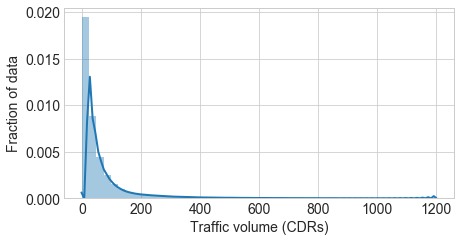

In [38]:
plot_single_histogram(full_raw)

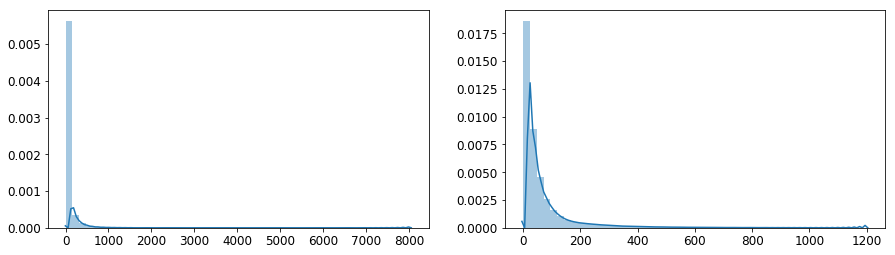

In [9]:
plot_histograms(train_raw)

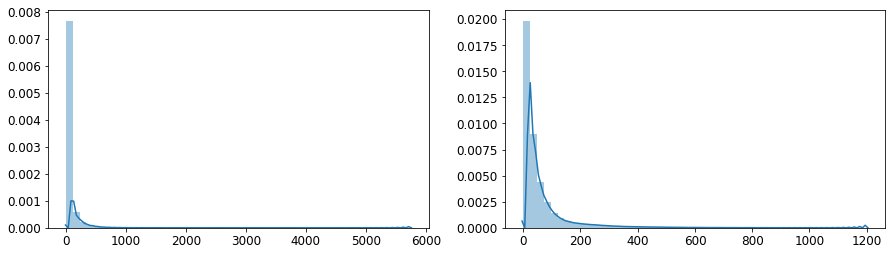

In [18]:
plot_single_histogram()

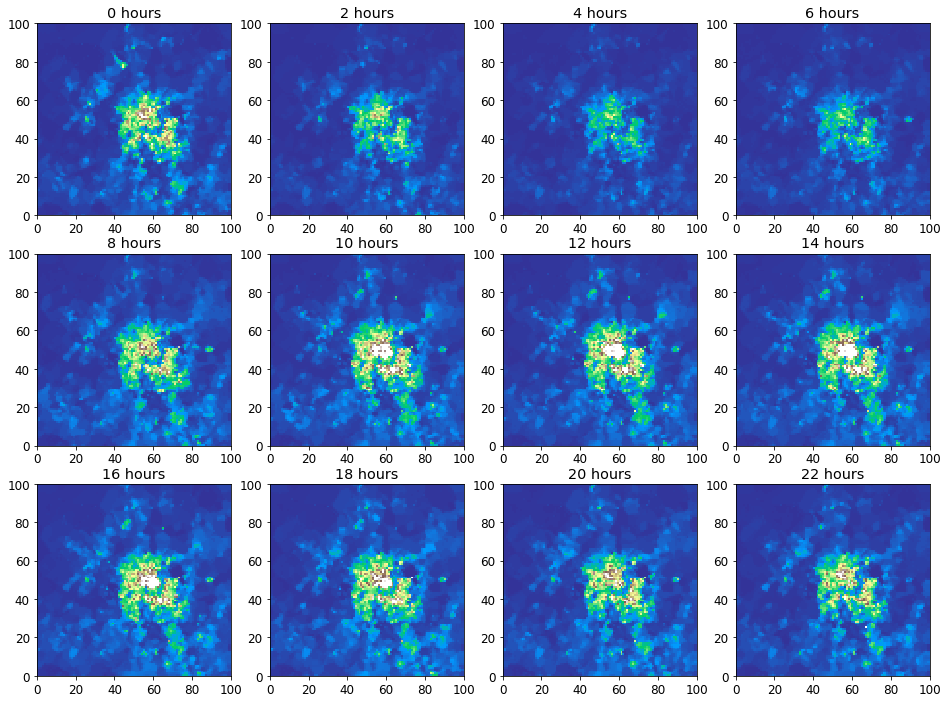

In [19]:
plt.figure(figsize=(16, 12))

for i in range(12): 
    index = i*12
    dots1 = val_raw[index]  # 96 is 15:00 UTC,  16:00 local Milan time
    
    plt.subplot(3, 4, i+1)
    plt.pcolormesh(dots1, cmap='terrain', vmin=dots1.min(), vmax=1000)
    
    hour = index // 6
    plt.title(f"{hour} hours")
#     plt.colorbar(label="Traffic volume")
# 
# 


## Correlation

In [42]:
coef = np.corrcoef(train_raw[:, 48, 60], train_raw[:, 49, 61])
print(coef)
train_raw.shape

[[1.        0.5934536]
 [0.5934536 1.       ]]


(6048, 100, 100)

In [49]:
def plot_grid(grid_data, colors='Blues', ticks=None, file=None):
    plt.rcParams.update({'font.size': 17})  
    plt.figure(figsize=(5, 4))
    plt.pcolormesh(grid_data, cmap=colors, vmin=grid_data.min(), vmax=grid_data.max())
    plt.colorbar(label="Correlation coefficient")

    plt.ylabel("y coordinate")
    plt.xlabel("x coordinate")
    
    if not ticks is None:
        x_ticks, x_labels, y_ticks, y_labels = ticks
        plt.xticks(x_ticks, x_labels)
        plt.yticks(y_ticks, y_labels)
        
    if file:
        plt.savefig(file)

    plt.tight_layout()


In [43]:
center_x, center_y = (41,55)
size = 19
coefficient_grid = np.zeros((size, size))
for i in range(size):
    for j in range(size):
        point_adjustment = size // 2
        coef = np.corrcoef(train_raw[:, center_x, center_y], 
                           train_raw[:, center_x + i - point_adjustment, center_y + j - point_adjustment])
                  
        # coef is a 2x2 matrix
        coefficient_grid[i,j] = coef[0,1]

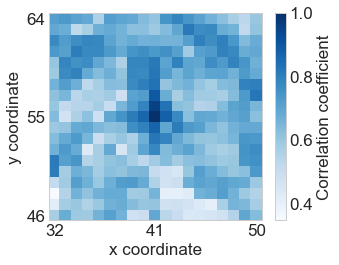

In [51]:
x_ticks, x_labels = [0.5, 9.5, 18.5], [32, 41, 50]
y_ticks, y_labels = [0.5, 9.5, 18.5], [46, 55, 64]
plot_grid(coefficient_grid, 'Blues', (x_ticks, x_labels, y_ticks, y_labels), "correlations.pdf")

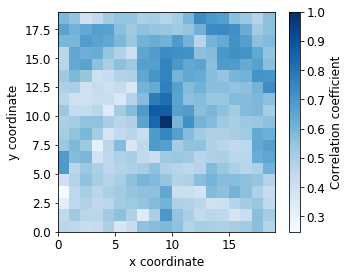

In [116]:
plot_grid(coefficient_grid, 'Blues')